In [1]:
import os
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
'''Plot room masks'''
mp3_path = '/checkpoint/medhini/mp3d'

home_count = 0
homes = os.listdir(mp3_path)
room_list = ['a', 'b', 'd', 'k', 'l']
all_missing = 0
for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
      
    line = lines[1].strip().split()
    
    #Coordinates of the house. 
    X1 = float(line[18])
    Y1 = float(line[19])
    X2 = float(line[21])
    Y2 = float(line[22])
    
    X_size = abs(X2 - X1)
    Y_size = abs(Y2 - Y1)
    
    floor_map = {}
    
    kitchen_count = 0
    for line in lines: 
        if line[0] == 'R':
            chars = line.strip().split()
            label = chars[5]
            if chars[2] == '0' and label in room_list:
                x1 = float(chars[9])
                y1 = float(chars[10])
                x2 = float(chars[12])
                y2 = float(chars[13])
                
                if label not in floor_map.keys():
                    floor_map[label] = np.zeros([100,100])   
                
                #Shift to first quadrant if bottom left corner of house is -ve 
                
                print(x1, x2, y1, y2)
                if X1 < 0:
                    x1 -= X1
                    x2 -= X1
                    
                if Y1 < 0:
                    y1 -= Y1
                    y2 -= Y1
                    
                #Scale
                x1 = math.ceil((x1/X_size)*100)
                x2 = math.ceil((x2/X_size)*100)
                y1 = math.ceil((y1/Y_size)*100)
                y2 = math.ceil((y2/Y_size)*100)
                    
                if x1 < 0 or y1 < 0:
                    print("Fails")
                
                floor_map[label][x1:x2, y1:y2] = 255
    
    
    if 'k' in floor_map.keys():
        if not os.path.exists('floor_plans/'+home):
            os.mkdir('floor_plans/'+home)
        print(home)
        for label, arr in floor_map.items():
            print(label)
            fn = os.path.join('floor_plans',home, label+'.png')
            img = Image.fromarray(arr.astype('uint8'))
            display(img)
            img.save(fn)
        missing=0
        for label in room_list:
            if label not in floor_map.keys():
                missing+=1
                print(label)
                fn = os.path.join('floor_plans',home, label+'.png')
                arr = np.zeros([100,100])
                img = Image.fromarray(arr.astype('uint8'))
                display(img)
                img.save(fn)
        if missing==4:
            all_missing+=1
#             print(home)
print(all_missing)

35.3931 38.7496 -12.2739 -7.07661


FileNotFoundError: [Errno 2] No such file or directory: 'floor_plans/B6ByNegPMKs'

In [15]:
'''Obtain correlation stats'''

mp3_path = '/checkpoint/medhini/mp3d'
homes = os.listdir(mp3_path)
room_list = ['a', 'b', 'c', 'd', 'e', 'k', 'l']
room_adjs = {}
room_count = {}

overlaps = 0

for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
    room_coord = {}
    coords = []
    
    for line in lines:
        if line[0] == 'R':
            chars = line.strip().split()
            label = chars[5]
            if chars[2] == '0' and label in room_list:
                if label in room_count.keys():
                    room_count[label] +=1
                else:
                    room_count[label] = 1
                    
                x1 = float(chars[9])
                y1 = float(chars[10])
                x2 = float(chars[12])
                y2 = float(chars[13])

                if label in room_coord.keys():
                    l = room_coord[label]
                    l.append([x1, y1, x2, y2])
                    room_coord[label] = l
                else:
                    room_coord[label] = [[x1, y1, x2, y2]]

                coords.append([x1, y1, x2, y2])
    flag = 0  
    
#     print(coords)
    for i in range(0,len(coords)):
        for j in range(i+1,len(coords)):
            x_left_1 = coords[i][0]
            x_right_1 = coords[i][2]
            y_top_1 = coords[i][1]
            y_bot_1 = coords[i][3]
            
            x_left_2 = coords[j][0]
            x_right_2 = coords[j][2]
            y_top_2 = coords[j][1]
            y_bot_2 = coords[j][3]
            
            if (x_left_1 < x_left_2 and x_left_2 < x_right_1) or (x_left_1 > x_left_2 and x_left_1 < x_right_2) or (y_bot_2 < y_bot_1 and y_top_2 < y_bot_1) or (y_top_2 > y_top_1 and y_top_1 < y_bot_2):
                overlaps += 1
                flag = 1
                break
                
        if flag == 1:
            break
        
    if 'k' in room_coord.keys():
        for label, coords in room_coord.items():
            for coord in coords:
                x_left_1 = coord[0]
                x_right_1 = coord[2]
                y_top_1 = coord[1]
                y_bot_1 = coord[3]

                if label not in room_adjs.keys():
                    room_adjs[label] = {}

                for label_2, coord_2 in room_coord.items():
                    if label_2 != label:
                        for coord2 in coord_2:
                            x_left_2 = coord2[0]
                            x_right_2 = coord2[2]
                            y_top_2 = coord2[1]
                            y_bot_2 = coord2[3]

                            if int(x_left_1) == int(x_right_2) or int(x_left_1) == int(x_left_2) or int(x_right_1) == int(x_right_2) or int(x_right_1) == int(x_left_2) or int(y_top_1) == int(y_top_2) or int(y_top_1) == int(y_bot_2) or int(y_bot_1) == int(y_top_2) or int(y_bot_1) == int(y_bot_2):
                                if label_2 in room_adjs[label].keys():
                                    room_adjs[label][label_2]+=1
                                else:
                                    room_adjs[label][label_2] = 1
        
print(overlaps)
print(room_count)
print(room_adjs)

65
{'k': 53, 'a': 143, 'b': 90, 'd': 48, 'l': 47, 'e': 50, 'c': 33}
{'k': {'a': 47, 'd': 37, 'l': 24, 'b': 26, 'e': 21, 'c': 11}, 'a': {'b': 103, 'l': 47, 'd': 48, 'k': 47, 'e': 33, 'c': 44}, 'b': {'a': 103, 'l': 34, 'd': 24, 'k': 26, 'e': 16, 'c': 28}, 'd': {'a': 48, 'b': 24, 'k': 37, 'l': 30, 'c': 8, 'e': 14}, 'l': {'a': 47, 'b': 34, 'k': 24, 'e': 23, 'd': 30, 'c': 5}, 'e': {'k': 21, 'b': 16, 'a': 33, 'l': 23, 'd': 14, 'c': 7}, 'c': {'l': 5, 'a': 44, 'd': 8, 'b': 28, 'k': 11, 'e': 7}}


In [13]:
from PIL import Image
img = Image.open('/private/home/medhini/mp3d_floor_plans/floor_plans/759xd9YjKW5/a.png')

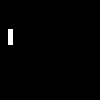

In [14]:
display(img)

B6ByNegPMKs
k


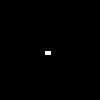

ARNzJeq3xxb
a


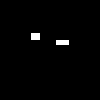

b


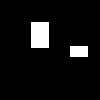

d


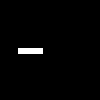

l


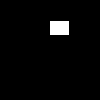

k


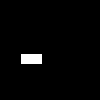

2t7WUuJeko7
l


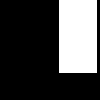

b


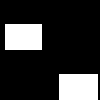

k


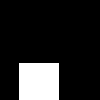

a


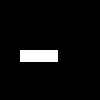

cV4RVeZvu5T
k


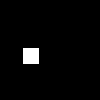

e


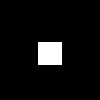

b


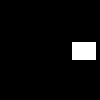

a


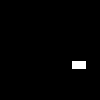

l


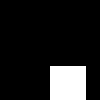

5LpN3gDmAk7
l


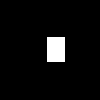

a


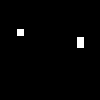

k


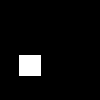

d


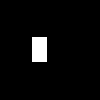

c


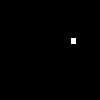

r1Q1Z4BcV1o
e


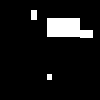

k


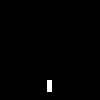

d


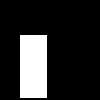

a


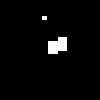

q9vSo1VnCiC
b


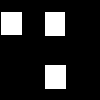

a


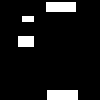

c


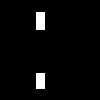

d


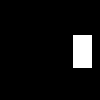

l


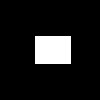

k


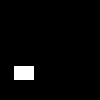

5ZKStnWn8Zo
k


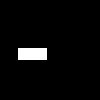

d


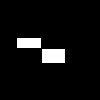

a


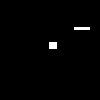

b


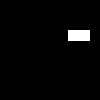

l


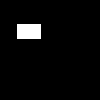

82sE5b5pLXE
k


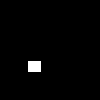

l


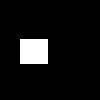

a


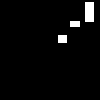

b


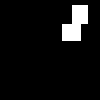

wc2JMjhGNzB
l


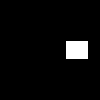

a


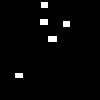

c


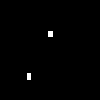

b


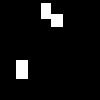

d


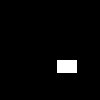

k


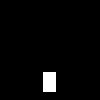

e


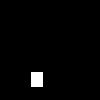

RPmz2sHmrrY
a


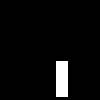

b


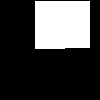

k


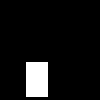

d


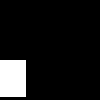

l


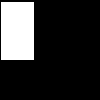

vyrNrziPKCB
b


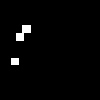

a


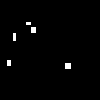

k


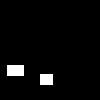

c


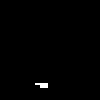

e


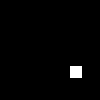

l


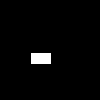

d


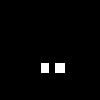

HxpKQynjfin
c


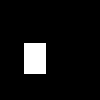

e


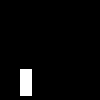

b


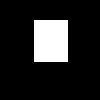

a


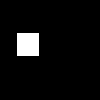

l


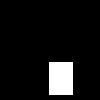

k


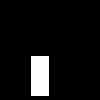

17DRP5sb8fy
b


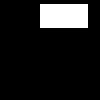

a


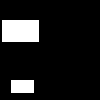

d


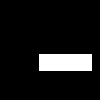

e


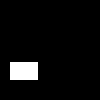

l


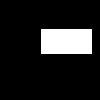

k


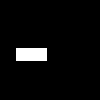

759xd9YjKW5
b


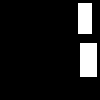

d


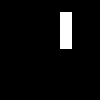

l


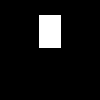

k


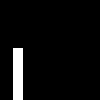

e


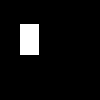

a


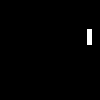

oLBMNvg9in8
k


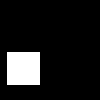

d


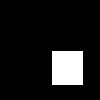

Vvot9Ly1tCj
b


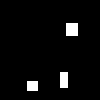

a


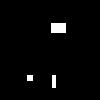

k


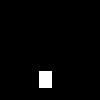

d


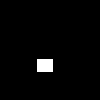

c


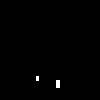

l


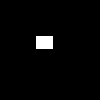

e


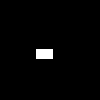

X7HyMhZNoso
d


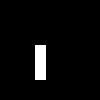

l


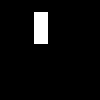

k


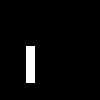

a


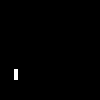

rPc6DW4iMge
k


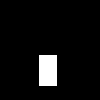

d


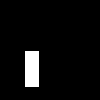

l


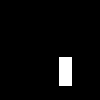

a


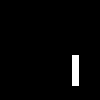

e


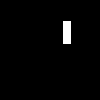

jh4fc5c5qoQ
b


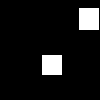

a


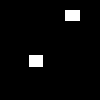

l


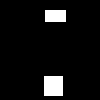

e


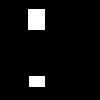

k


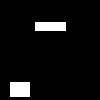

sT4fr6TAbpF
b


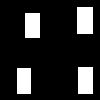

a


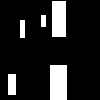

k


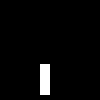

l


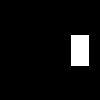

d


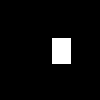

ac26ZMwG7aT
b


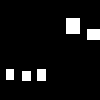

a


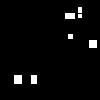

k


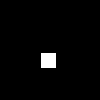

d


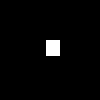

l


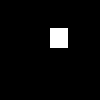

c


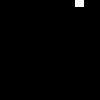

aayBHfsNo7d
d


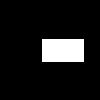

a


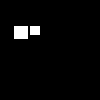

e


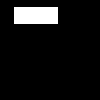

l


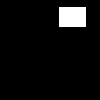

k


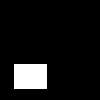

GdvgFV5R1Z5
k


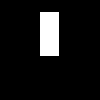

e


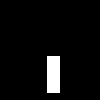

b


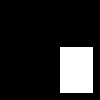

d


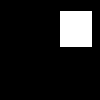

l


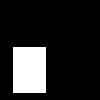

a


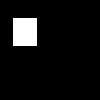

1pXnuDYAj8r
a


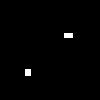

c


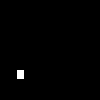

k


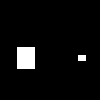

d


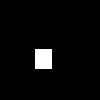

l


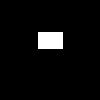

b


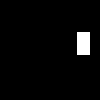

e


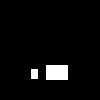

kEZ7cmS4wCh
l


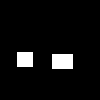

d


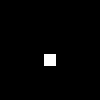

k


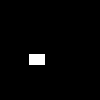

e


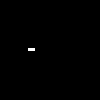

b


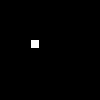

a


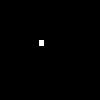

VzqfbhrpDEA
b


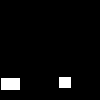

a


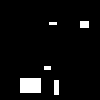

c


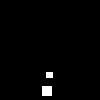

k


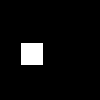

d


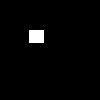

e


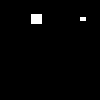

l


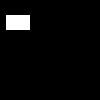

2azQ1b91cZZ
l


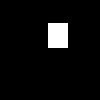

d


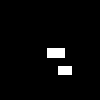

k


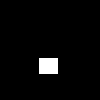

e


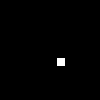

a


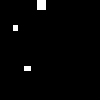

b


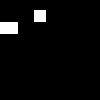

c


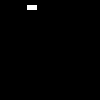

JmbYfDe2QKZ
l


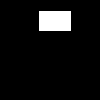

d


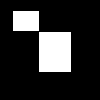

a


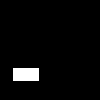

k


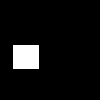

e


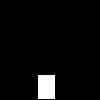

WYY7iVyf5p8
b


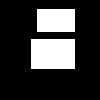

a


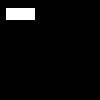

k


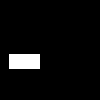

mJXqzFtmKg4
l


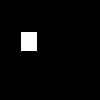

d


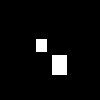

b


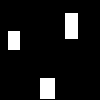

a


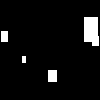

e


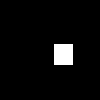

c


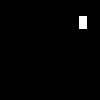

k


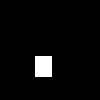

b8cTxDM8gDG
b


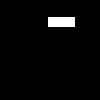

a


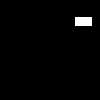

e


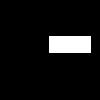

k


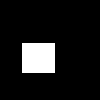

l


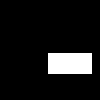

JF19kD82Mey
k


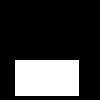

e


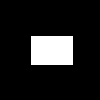

a


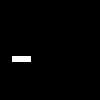

l


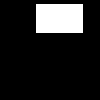

8194nk5LbLH
k


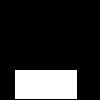

Uxmj2M2itWa
b


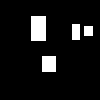

a


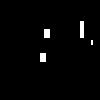

k


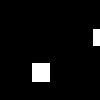

l


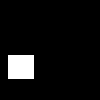

e


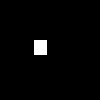

c


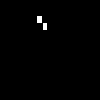

EDJbREhghzL
l


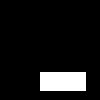

k


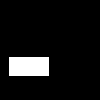

d


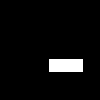

b


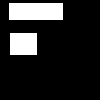

a


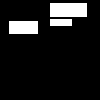

ZMojNkEp431
k


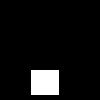

e


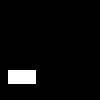

8WUmhLawc2A
b


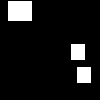

a


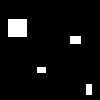

d


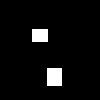

c


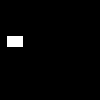

l


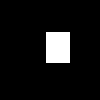

k


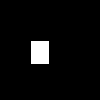

S9hNv5qa7GM
a


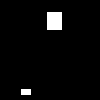

d


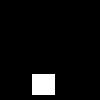

b


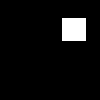

l


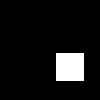

k


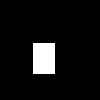

uNb9QFRL6hY
b


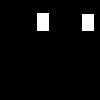

a


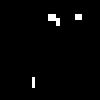

c


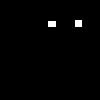

d


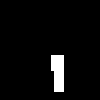

k


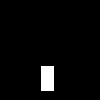

l


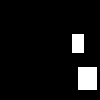

e


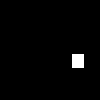

JeFG25nYj2p
b


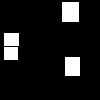

a


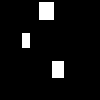

k


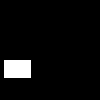

d


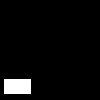

l


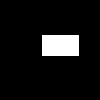

c


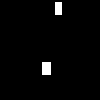

YFuZgdQ5vWj
a


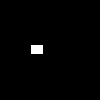

k


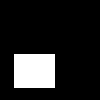

l


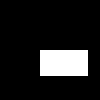

e


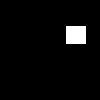

i5noydFURQK
l


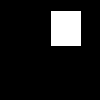

a


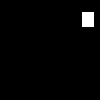

d


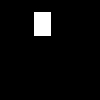

k


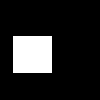

qoiz87JEwZ2
e


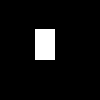

l


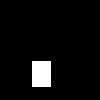

a


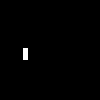

d


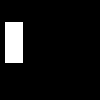

k


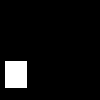

YVUC4YcDtcY
e


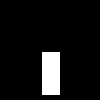

k


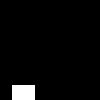

d


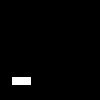

jtcxE69GiFV
d


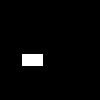

l


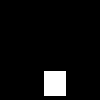

a


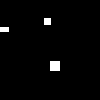

k


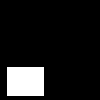

b


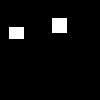

e


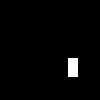

zsNo4HB9uLZ
b


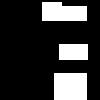

e


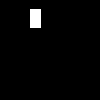

a


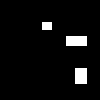

d


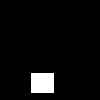

k


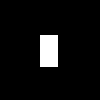

l


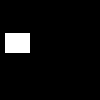

c


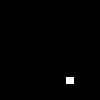

ULsKaCPVFJR
e


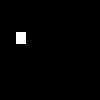

d


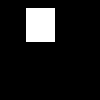

k


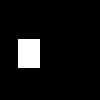

b


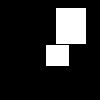

a


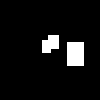

c


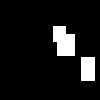

l


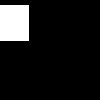

29hnd4uzFmX
b


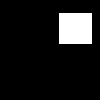

a


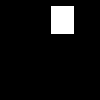

e


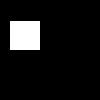

k


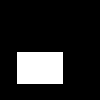

l


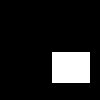

In [15]:
'''Align room masks'''
mp3_path = '/checkpoint/medhini/mp3d'

home_count = 0
homes = os.listdir(mp3_path)
room_list = ['a', 'b', 'c', 'd', 'e', 'k', 'l']

for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
      
    line = lines[1].strip().split()
    
    #Coordinates of the house. 
    X1 = float(line[18])
    Y1 = float(line[19])
    X2 = float(line[21])
    Y2 = float(line[22])
    
    X_size = abs(X2 - X1)
    Y_size = abs(Y2 - Y1)
    
    
    floor_map = {}
    
    kitchen_count = 0
    for line in lines: 
        if line[0] == 'R':
            chars = line.strip().split()
            label = chars[5]
            if chars[2] == '0' and label in room_list:
                x1 = float(chars[9])
                y1 = float(chars[10])
                x2 = float(chars[12])
                y2 = float(chars[13])
                
                if label not in floor_map.keys():
                    floor_map[label] = np.zeros([100,100])   
                
                #Shift to first quadrant
                if X1 < 0:
                    x1 -= X1
                    x2 -= X1
                    
                if Y1 < 0:
                    y1 -= Y1
                    y2 -= Y1
                    
                "Scale"
                x1 = math.ceil((x1/X_size)*100)
                x2 = math.ceil((x2/X_size)*100)
                y1 = math.ceil((y1/Y_size)*100)
                y2 = math.ceil((y2/Y_size)*100)
                    
                if x1 < 0 or y1 < 0:
                    print("Fails")
                
                floor_map[label][x1:x2, y1:y2] = 255
    
    if 'k' in floor_map.keys():
        if np.count_nonzero(floor_map['k'][:50,:50])>(np.count_nonzero(floor_map['k'][50:,50:]) + np.count_nonzero(floor_map['k'][:50,50:]) + np.count_nonzero(floor_map['k'][50:,:50])):
            for label, arr in floor_map.items():
                n_arr = arr[::-1, :]
                floor_map[label] = n_arr
        elif np.count_nonzero(floor_map['k'][50:,50:])>(np.count_nonzero(floor_map['k'][50:,:50]) + np.count_nonzero(floor_map['k'][:50,50:]) + np.count_nonzero(floor_map['k'][:50,:50])):
            for label, arr in floor_map.items():
                n_arr = arr[:, ::-1]
                floor_map[label] = n_arr
        elif np.count_nonzero(floor_map['k'][:50,50:])>(np.count_nonzero(floor_map['k'][50:,:50]) + np.count_nonzero(floor_map['k'][50:,50:]) + np.count_nonzero(floor_map['k'][:50,:50])):
            for label, arr in floor_map.items():
                n_arr = arr[::-1, ::-1]
                floor_map[label] = n_arr
    
    if 'k' in floor_map.keys():
        if not os.path.exists('floor_plans_aligned/'+home):
            os.mkdir('floor_plans_aligned/'+home)
        print(home)
        for label, arr in floor_map.items():
            print(label)
            fn = os.path.join('floor_plans_aligned',home, label+'.png')
            img = Image.fromarray(arr.astype('uint8'))
            display(img)
            img.save(fn)    

In [2]:
'''Average lengths of homes'''

mp3_path = '/checkpoint/medhini/mp3d'

homes = os.listdir(mp3_path)

avg_x = 0
avg_y = 0
min_x = 10000000
min_y = 10000000

max_x = -1
max_y = -1

all_x = []
all_y = []

for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
    
    line = lines[1].strip().split()
    x1 = float(line[18])
    y1 = float(line[19])
    x2 = float(line[21])
    y2 = float(line[22])
    
    print(home, abs(float(x2 - x1)), abs(float(y2 - y1)))
    
    avg_x += abs(float(x2 - x1))
    avg_y += abs(float(y2 - y1))
    
    all_x.append(abs(float(x2 - x1)))
    all_y.append(abs(float(y2 - y1)))
    
    min_x = min(abs(float(x2 - x1)), min_x)
        
    min_y = min(abs(float(y2 - y1)), min_y)
    
    max_x = max(abs(float(x2 - x1)), max_x)
        
    max_y = max(abs(float(y2 - y1)), max_y)
    
        
avg_x /= len(homes)
avg_y /= len(homes)

print('Avg: ', avg_x, avg_y)
print('Min: ', min_x, min_y)
print('Max: ', max_x, max_y)
print('Median: ', np.median(np.array(all_x)), np.median(np.array(all_y)))


B6ByNegPMKs 99.14241 83.5801
gTV8FGcVJC9 46.982 36.17763
ARNzJeq3xxb 39.03626 17.735770000000002
pRbA3pwrgk9 11.67327 17.45223
2t7WUuJeko7 11.82759 10.00377
SN83YJsR3w2 36.4963 45.0797
cV4RVeZvu5T 19.19451 20.43366
fzynW3qQPVF 52.34394 46.6359
Z6MFQCViBuw 42.46635 28.32615
5LpN3gDmAk7 27.61509 27.615109999999998
QUCTc6BB5sX 29.2868 45.688900000000004
r1Q1Z4BcV1o 43.47935 46.7143
q9vSo1VnCiC 27.8176 19.33912
sKLMLpTHeUy 31.62153 10.26347
Pm6F8kyY3z2 10.683679999999999 23.237499999999997
5ZKStnWn8Zo 42.880300000000005 20.6128
82sE5b5pLXE 36.93999 31.05547
wc2JMjhGNzB 37.74562 37.7457
EU6Fwq7SyZv 17.41618 13.18839
RPmz2sHmrrY 8.55744 13.886422
vyrNrziPKCB 49.4045 46.3645
rqfALeAoiTq 26.89568 11.76863
D7G3Y4RVNrH 4.99167 13.903730000000001
HxpKQynjfin 7.26507 11.197859999999999
Vt2qJdWjCF2 76.28540000000001 44.6185
17DRP5sb8fy 17.57338 8.85955
yqstnuAEVhm 13.598700000000001 20.95043
VLzqgDo317F 29.0871 27.436709999999998
PuKPg4mmafe 50.8929 74.7464
V2XKFyX4ASd 11.425709999999999 15.23686
7

k


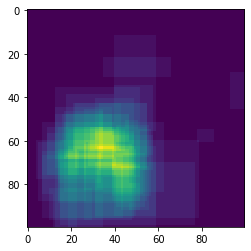

a


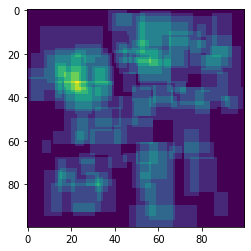

b


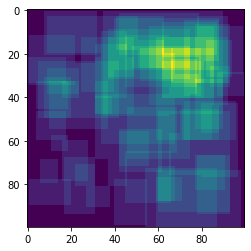

d


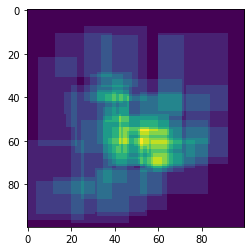

l


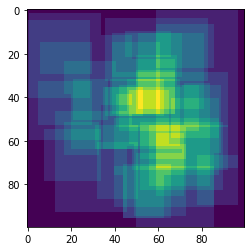

e


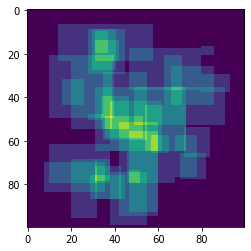

c


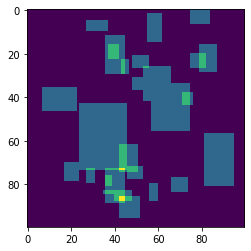

In [22]:
'''Average of Scaled Semantic Maps Aligned by kithcen'''

mp3_path = '/checkpoint/medhini/mp3d'

home_count = 0
homes = os.listdir(mp3_path)
room_list = ['a', 'b', 'c', 'd', 'e', 'k', 'l']

all_maps = {}
room_count = {}

for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
      
    line = lines[1].strip().split()
    
    #Coordinates of the house. 
    X1 = float(line[18])
    Y1 = float(line[19])
    X2 = float(line[21])
    Y2 = float(line[22])
    
    X_size = abs(X2 - X1)
    Y_size = abs(Y2 - Y1)
    
    
    floor_map = {}
    
    kitchen_count = 0
    for line in lines: 
        if line[0] == 'R':
            chars = line.strip().split()
            label = chars[5]
            if chars[2] == '0' and label in room_list:
                if label in room_count.keys():
                    room_count[label] +=1
                else:
                    room_count[label] = 1
                    
                x1 = float(chars[9])
                y1 = float(chars[10])
                x2 = float(chars[12])
                y2 = float(chars[13])
                
                if label not in floor_map.keys():
                    floor_map[label] = np.zeros([100,100])   
                
                #Shift to first quadrant
                if X1 < 0:
                    x1 -= X1
                    x2 -= X1
                    
                if Y1 < 0:
                    y1 -= Y1
                    y2 -= Y1
                    
                "Scale"
                x1 = math.ceil((x1/X_size)*100)
                x2 = math.ceil((x2/X_size)*100)
                y1 = math.ceil((y1/Y_size)*100)
                y2 = math.ceil((y2/Y_size)*100)
                    
                if x1 < 0 or y1 < 0:
                    print("Fails")
                
                floor_map[label][x1:x2, y1:y2] = 255
    
    #Align by Kitchen
    if 'k' in floor_map.keys():
        if np.count_nonzero(floor_map['k'][:50,:50])>(np.count_nonzero(floor_map['k'][50:,50:]) + np.count_nonzero(floor_map['k'][:50,50:]) + np.count_nonzero(floor_map['k'][50:,:50])):
            for label, arr in floor_map.items():
                n_arr = arr[::-1, :]
                floor_map[label] = n_arr
        elif np.count_nonzero(floor_map['k'][50:,50:])>(np.count_nonzero(floor_map['k'][50:,:50]) + np.count_nonzero(floor_map['k'][:50,50:]) + np.count_nonzero(floor_map['k'][:50,:50])):
            for label, arr in floor_map.items():
                n_arr = arr[:, ::-1]
                floor_map[label] = n_arr
        elif np.count_nonzero(floor_map['k'][:50,50:])>(np.count_nonzero(floor_map['k'][50:,:50]) + np.count_nonzero(floor_map['k'][50:,50:]) + np.count_nonzero(floor_map['k'][:50,:50])):
            for label, arr in floor_map.items():
                n_arr = arr[::-1, ::-1]
                floor_map[label] = n_arr
                
    if 'k' in floor_map.keys():
        for label, arr in floor_map.items():
            if label in all_maps:
                all_maps[label] += arr
            else:
                all_maps[label] = arr
    
for label in all_maps.keys():
    arr = all_maps[label]/room_count[label]
    print(label)
    plt.imshow(arr)
    plt.imsave('Aligned_scaled_%s.jpg'%label, arr)
    plt.show()
        

k


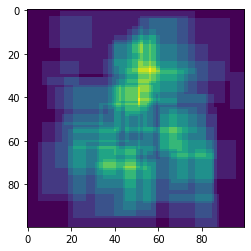

a


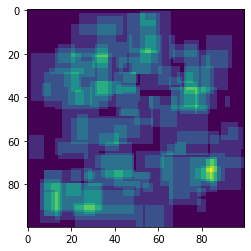

b


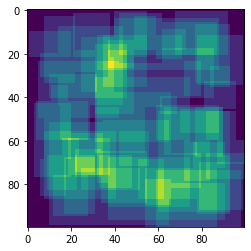

d


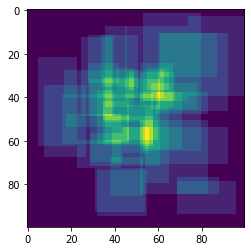

l


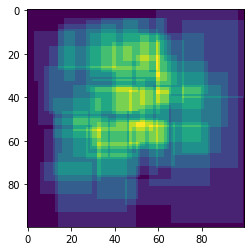

e


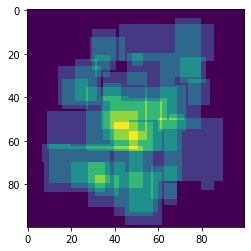

c


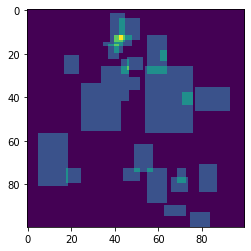

In [23]:
'''Average of Scaled Semantic Maps without alignement'''

mp3_path = '/checkpoint/medhini/mp3d'

home_count = 0
homes = os.listdir(mp3_path)
room_list = ['a', 'b', 'c', 'd', 'e', 'k', 'l']

all_maps = {}
for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
      
    line = lines[1].strip().split()
    
    #Coordinates of the house. 
    X1 = float(line[18])
    Y1 = float(line[19])
    X2 = float(line[21])
    Y2 = float(line[22])
    
    X_size = abs(X2 - X1)
    Y_size = abs(Y2 - Y1)
    
    
    floor_map = {}
    
    kitchen_count = 0
    for line in lines: 
        if line[0] == 'R':
            chars = line.strip().split()
            label = chars[5]
            if chars[2] == '0' and label in room_list:
                x1 = float(chars[9])
                y1 = float(chars[10])
                x2 = float(chars[12])
                y2 = float(chars[13])
                
                if label not in floor_map.keys():
                    floor_map[label] = np.zeros([100,100])   
                
                #Shift to first quadrant
                if X1 < 0:
                    x1 -= X1
                    x2 -= X1
                    
                if Y1 < 0:
                    y1 -= Y1
                    y2 -= Y1
                    
                #Scale
                x1 = math.ceil((x1/X_size)*100)
                x2 = math.ceil((x2/X_size)*100)
                y1 = math.ceil((y1/Y_size)*100)
                y2 = math.ceil((y2/Y_size)*100)
                    
                if x1 < 0 or y1 < 0:
                    print("Fails")
                
                floor_map[label][x1:x2, y1:y2] = 255
                
    if 'k' in floor_map.keys():
        for label, arr in floor_map.items():
            if label in all_maps:
                all_maps[label] += arr
            else:
                all_maps[label] = arr
    
for label in all_maps.keys():
    arr = all_maps[label]/room_count[label]
    print(label)
    plt.imshow(arr)
    plt.imsave('Scaled_%s.jpg'%label, arr)
    plt.show()
        

k


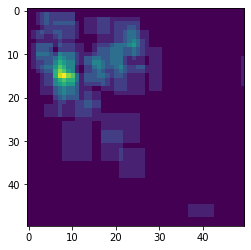

a


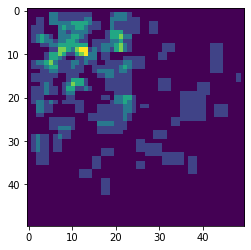

b


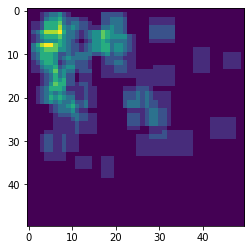

d


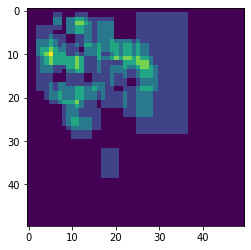

l


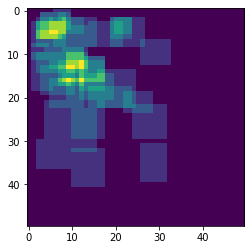

e


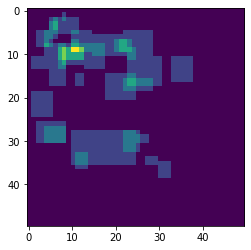

c


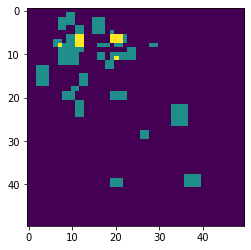

In [6]:
'''Average of Semantic Maps - no scaling, no alignement'''

mp3_path = '/checkpoint/medhini/mp3d'

home_count = 0
homes = os.listdir(mp3_path)
room_list = ['a', 'b', 'c', 'd', 'e', 'k', 'l']

all_maps = {}
room_count = {}
for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
      
    line = lines[1].strip().split()
    
    #Coordinates of the house. 
    X1 = float(line[18])
    Y1 = float(line[19])
    X2 = float(line[21])
    Y2 = float(line[22])
    
    X_size = abs(X2 - X1)
    Y_size = abs(Y2 - Y1)
    
    
    floor_map = {}
    
    kitchen_count = 0
    for line in lines: 
        if line[0] == 'R':
            chars = line.strip().split()
            label = chars[5]
            if chars[2] == '0' and label in room_list:
                if label in room_count.keys():
                    room_count[label] +=1
                else:
                    room_count[label] = 1
                x1 = float(chars[9])
                y1 = float(chars[10])
                x2 = float(chars[12])
                y2 = float(chars[13])
                
                if label not in floor_map.keys():
                    floor_map[label] = np.zeros([50,50])   
                
                #Shift to first quadrant
                if X1 < 0:
                    x1 -= X1
                    x2 -= X1
                    
                if Y1 < 0:
                    y1 -= Y1
                    y2 -= Y1
                
                x1 = math.ceil(x1)
                x2 = math.ceil(x2)
                y1 = math.ceil(y1)
                y2 = math.ceil(y2)
                
                floor_map[label][x1:x2, y1:y2] = 255
                
    if 'k' in floor_map.keys():
        for label, arr in floor_map.items():
            if label in all_maps:
                all_maps[label] += arr
            else:
                all_maps[label] = arr
    
for label in all_maps.keys():
    arr = all_maps[label]/room_count[label]
    print(label)
    plt.imshow(arr)
    plt.imsave('Not_Scaled_Not_Aligned_%s.jpg'%label, arr)
    plt.show()

k


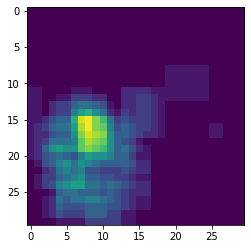

a


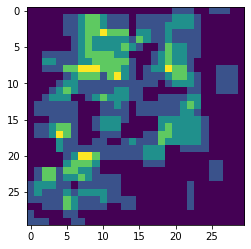

b


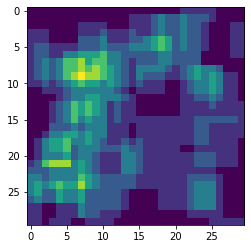

d


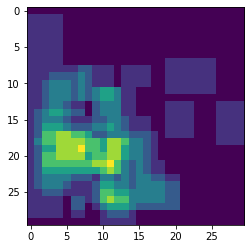

l


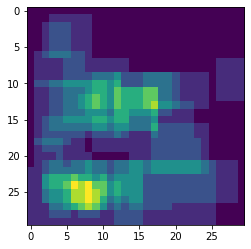

e


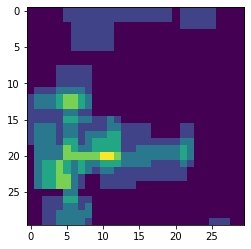

c


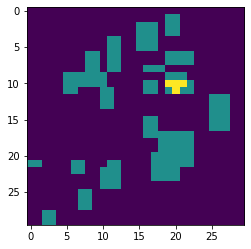

In [7]:
'''Average of Cropped Semantic Maps with alignement'''

mp3_path = '/checkpoint/medhini/mp3d'

home_count = 0
homes = os.listdir(mp3_path)
room_list = ['a', 'b', 'c', 'd', 'e', 'k', 'l']

all_maps = {}
room_count = {}

for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
      
    line = lines[1].strip().split()
    
    #Coordinates of the house. 
    X1 = float(line[18])
    Y1 = float(line[19])
    X2 = float(line[21])
    Y2 = float(line[22])
    
    X_size = abs(X2 - X1)
    Y_size = abs(Y2 - Y1)
    
    
    floor_map = {}
    
    kitchen_count = 0
    for line in lines: 
        if line[0] == 'R':
            chars = line.strip().split()
            label = chars[5]
            if chars[2] == '0' and label in room_list:
                if label in room_count.keys():
                    room_count[label] +=1
                else:
                    room_count[label] = 1
                    
                x1 = float(chars[9])
                y1 = float(chars[10])
                x2 = float(chars[12])
                y2 = float(chars[13])
                
                if label not in floor_map.keys():
                    floor_map[label] = np.zeros([30,30])   
                
                #Shift to first quadrant
                if X1 < 0:
                    x1 -= X1
                    x2 -= X1
                    
                if Y1 < 0:
                    y1 -= Y1
                    y2 -= Y1
                    
                x1 = math.ceil(x1)
                x2 = math.ceil(x2)
                y1 = math.ceil(y1)
                y2 = math.ceil(y2)
                    
                if x1 < 0 or y1 < 0:
                    print("Fails")
                
                floor_map[label][x1:x2, y1:y2] = 255
    
    #Align by Kitchen
    if 'k' in floor_map.keys():
        if np.count_nonzero(floor_map['k'][:15,:15])>(np.count_nonzero(floor_map['k'][15:,15:]) + np.count_nonzero(floor_map['k'][:15,15:]) + np.count_nonzero(floor_map['k'][15:,:15])):
            for label, arr in floor_map.items():
                n_arr = arr[::-1, :]
                floor_map[label] = n_arr
        elif np.count_nonzero(floor_map['k'][15:,15:])>(np.count_nonzero(floor_map['k'][15:,:15]) + np.count_nonzero(floor_map['k'][:15,15:]) + np.count_nonzero(floor_map['k'][:15,:15])):
            for label, arr in floor_map.items():
                n_arr = arr[:, ::-1]
                floor_map[label] = n_arr
        elif np.count_nonzero(floor_map['k'][:15,15:])>(np.count_nonzero(floor_map['k'][15:,:15]) + np.count_nonzero(floor_map['k'][15:,15:]) + np.count_nonzero(floor_map['k'][:15,:15])):
            for label, arr in floor_map.items():
                n_arr = arr[::-1, ::-1]
                floor_map[label] = n_arr
                
    if 'k' in floor_map.keys():
        for label, arr in floor_map.items():
            if label in all_maps:
                all_maps[label] += arr
            else:
                all_maps[label] = arr
    
for label in all_maps.keys():
    arr = all_maps[label]/room_count[label]
    print(label)
    plt.imshow(arr)
    plt.imsave('Cropped_aligned_%s.jpg'%label, arr)
    plt.show()

k


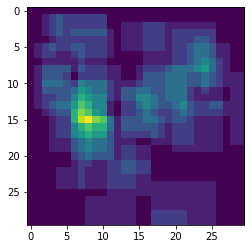

a


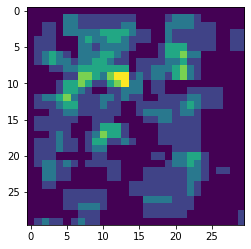

b


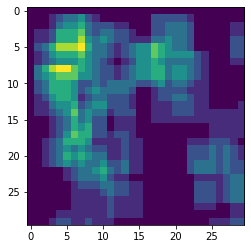

d


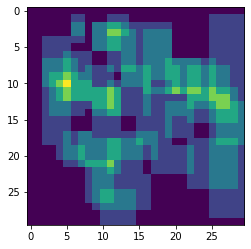

l


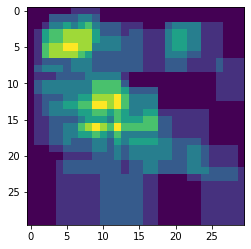

e


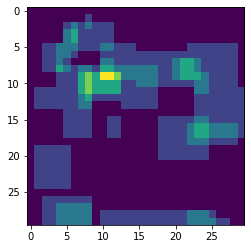

c


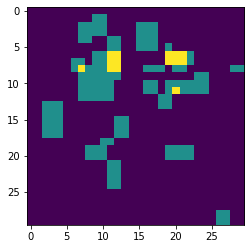

In [8]:
'''Average of Cropped Semantic Maps with no alignement'''

mp3_path = '/checkpoint/medhini/mp3d'

home_count = 0
homes = os.listdir(mp3_path)
room_list = ['a', 'b', 'c', 'd', 'e', 'k', 'l']

all_maps = {}
room_count = {}

for home in homes:
    lines = open(os.path.join(mp3_path, home, home+'.house')).readlines()
      
    line = lines[1].strip().split()
    
    #Coordinates of the house. 
    X1 = float(line[18])
    Y1 = float(line[19])
    X2 = float(line[21])
    Y2 = float(line[22])
    
    X_size = abs(X2 - X1)
    Y_size = abs(Y2 - Y1)
    
    
    floor_map = {}
    
    kitchen_count = 0
    for line in lines: 
        if line[0] == 'R':
            chars = line.strip().split()
            label = chars[5]
            if chars[2] == '0' and label in room_list:
                if label in room_count.keys():
                    room_count[label] +=1
                else:
                    room_count[label] = 1
                    
                x1 = float(chars[9])
                y1 = float(chars[10])
                x2 = float(chars[12])
                y2 = float(chars[13])
                
                if label not in floor_map.keys():
                    floor_map[label] = np.zeros([30,30])   
                
                #Shift to first quadrant
                if X1 < 0:
                    x1 -= X1
                    x2 -= X1
                    
                if Y1 < 0:
                    y1 -= Y1
                    y2 -= Y1
                    
                x1 = math.ceil(x1)
                x2 = math.ceil(x2)
                y1 = math.ceil(y1)
                y2 = math.ceil(y2)
                    
                if x1 < 0 or y1 < 0:
                    print("Fails")
                
                floor_map[label][x1:x2, y1:y2] = 255
    
    #Align by Kitchen
#     if 'k' in floor_map.keys():
#         if np.count_nonzero(floor_map['k'][:15,:15])>(np.count_nonzero(floor_map['k'][15:,15:]) + np.count_nonzero(floor_map['k'][:15,15:]) + np.count_nonzero(floor_map['k'][15:,:15])):
#             for label, arr in floor_map.items():
#                 n_arr = arr[::-1, :]
#                 floor_map[label] = n_arr
#         elif np.count_nonzero(floor_map['k'][15:,15:])>(np.count_nonzero(floor_map['k'][15:,:15]) + np.count_nonzero(floor_map['k'][:15,15:]) + np.count_nonzero(floor_map['k'][:15,:15])):
#             for label, arr in floor_map.items():
#                 n_arr = arr[:, ::-1]
#                 floor_map[label] = n_arr
#         elif np.count_nonzero(floor_map['k'][:15,15:])>(np.count_nonzero(floor_map['k'][15:,:15]) + np.count_nonzero(floor_map['k'][15:,15:]) + np.count_nonzero(floor_map['k'][:15,:15])):
#             for label, arr in floor_map.items():
#                 n_arr = arr[::-1, ::-1]
#                 floor_map[label] = n_arr
                
    if 'k' in floor_map.keys():
        for label, arr in floor_map.items():
            if label in all_maps:
                all_maps[label] += arr
            else:
                all_maps[label] = arr
    
for label in all_maps.keys():
    arr = all_maps[label]/room_count[label]
    print(label)
    plt.imshow(arr)
    plt.imsave('Cropped_not_aligned_%s.jpg'%label, arr)
    plt.show()

In [19]:
from PIL import Image

img= np.asarray(Image.open('/private/home/medhini/mp3d_floor_plans/floor_plans/r1Q1Z4BcV1o/a.png'))
img = img.astype(np.float32)

In [20]:
img

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)